In [2]:
!git clone https://github.com/pratikkayal/PlantDoc-Dataset.git


Cloning into 'PlantDoc-Dataset'...
remote: Enumerating objects: 2670, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 2670 (delta 22), reused 22 (delta 22), pack-reused 2635 (from 1)
Receiving objects: 100% (2670/2670), 932.92 MiB | 17.48 MiB/s, done.
Resolving deltas: 100% (24/24), done.
Updating files: 100% (2581/2581), done.


In [3]:
import os
os.listdir("/content")


['.config', 'PlantDoc-Dataset', 'sample_data']

In [4]:
import os

for root, dirs, files in os.walk("/content/PlantDoc-Dataset"):
    print(f"\n Folder: {root}")
    for d in dirs:
        print(f"  Subfolder: {d}")
    for f in files[:5]:  # just printing first 5 files to keep output short
        print(f"   File: {f}")
    break  # remove this to go deeper into subfolders



 Folder: /content/PlantDoc-Dataset
  Subfolder: .git
  Subfolder: train
  Subfolder: test
   File: README.md
   File: PlantDoc_Examples.png
   File: LICENSE.txt


In [5]:
import os

train_path = "/content/PlantDoc-Dataset/train"
test_path = "/content/PlantDoc-Dataset/test"

print("Train Classes:", os.listdir(train_path)[:5])
print("Test Classes:", os.listdir(test_path)[:5])

Train Classes: ['Tomato mold leaf', 'Bell_pepper leaf', 'Tomato Early blight leaf', 'Apple leaf', 'Tomato leaf mosaic virus']
Test Classes: ['Tomato mold leaf', 'Bell_pepper leaf', 'Tomato Early blight leaf', 'Apple leaf', 'Tomato leaf mosaic virus']


In [13]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader, random_split

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_path = "/content/PlantDoc-Dataset/train"
test_path = "/content/PlantDoc-Dataset/test"

train_dataset = ImageFolder(root=train_path,  transform=train_transforms)
test_dataset = ImageFolder(root=test_path,  transform=val_transforms)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_ds, val_ds = random_split(train_dataset, [train_size, val_size])

val_ds.dataset.transform = val_transforms


train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


print("Total Classes:", len(train_dataset.classes))
print("Class Names:", train_dataset.classes)


Total Classes: 28
Class Names: ['Apple Scab Leaf', 'Apple leaf', 'Apple rust leaf', 'Bell_pepper leaf', 'Bell_pepper leaf spot', 'Blueberry leaf', 'Cherry leaf', 'Corn Gray leaf spot', 'Corn leaf blight', 'Corn rust leaf', 'Peach leaf', 'Potato leaf early blight', 'Potato leaf late blight', 'Raspberry leaf', 'Soyabean leaf', 'Squash Powdery mildew leaf', 'Strawberry leaf', 'Tomato Early blight leaf', 'Tomato Septoria leaf spot', 'Tomato leaf', 'Tomato leaf bacterial spot', 'Tomato leaf late blight', 'Tomato leaf mosaic virus', 'Tomato leaf yellow virus', 'Tomato mold leaf', 'Tomato two spotted spider mites leaf', 'grape leaf', 'grape leaf black rot']


In [14]:
import torchvision.models as models
import torch.nn as nn

def get_model(num_classes=28):
    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model


In [18]:
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn as nn
import torchvision.models as models

def get_model(num_classes=28):
    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = get_model(num_classes=28).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [19]:
import torch
import copy

epochs = 20
best_acc = 0.0
patience = 5
counter = 0
best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = 100 * correct / total
    scheduler.step()


    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = 100 * val_correct / val_total

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(best_model_wts, "best_crophealthnet.pth")
        counter = 0
        print(f"  Best model updated at epoch {epoch+1} (Val Acc: {val_acc:.2f}%)")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break


model.load_state_dict(best_model_wts)


dummy_input = torch.randn(1, 3, 224, 224).to(device)
scripted_model = torch.jit.trace(model, dummy_input)
scripted_model.save("crophealthnet_scripted.pt")
print("TorchScript model saved.")

Epoch 1/20 | Train Loss: 2.8935 | Train Acc: 19.81% | Val Acc: 30.49%
✔️  Best model updated at epoch 1 (Val Acc: 30.49%)
Epoch 2/20 | Train Loss: 2.1533 | Train Acc: 42.07% | Val Acc: 39.87%
✔️  Best model updated at epoch 2 (Val Acc: 39.87%)
Epoch 3/20 | Train Loss: 1.7905 | Train Acc: 52.43% | Val Acc: 45.20%
✔️  Best model updated at epoch 3 (Val Acc: 45.20%)
Epoch 4/20 | Train Loss: 1.5716 | Train Acc: 57.07% | Val Acc: 43.28%
Epoch 5/20 | Train Loss: 1.4140 | Train Acc: 61.08% | Val Acc: 49.25%
✔️  Best model updated at epoch 5 (Val Acc: 49.25%)
Epoch 6/20 | Train Loss: 1.2989 | Train Acc: 64.55% | Val Acc: 47.33%
Epoch 7/20 | Train Loss: 1.2127 | Train Acc: 66.58% | Val Acc: 47.33%
Epoch 8/20 | Train Loss: 1.1303 | Train Acc: 69.25% | Val Acc: 49.89%
✔️  Best model updated at epoch 8 (Val Acc: 49.89%)
Epoch 9/20 | Train Loss: 1.0735 | Train Acc: 69.94% | Val Acc: 46.91%
Epoch 10/20 | Train Loss: 1.0191 | Train Acc: 71.65% | Val Acc: 47.97%
Epoch 11/20 | Train Loss: 0.9357 | Trai

In [1]:
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch

def analyze_image(image_path):
    import cv2
    from PIL import Image
    import matplotlib.pyplot as plt
    import numpy as np
    import torch

    model.eval()

    img = Image.open(image_path).convert('RGB')
    input_tensor = val_transforms(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        probs = torch.softmax(output, dim=1)
        score, pred_class = torch.max(probs, dim=1)

    label = train_dataset.classes[pred_class.item()]
    score = score.item()

    print(f"\n Prediction: {label} | Trust Score: {score:.2f}")

    def forward_hook(module, input, output):
        nonlocal features
        features = output

    def backward_hook(module, grad_in, grad_out):
        nonlocal gradients
        gradients = grad_out[0]

    features = gradients = None
    target_layer = model.layer4[1].conv2
    fwd = target_layer.register_forward_hook(forward_hook)
    bwd = target_layer.register_backward_hook(backward_hook)

    output = model(input_tensor)
    class_score = output[0, pred_class]
    model.zero_grad()
    class_score.backward()


    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    for i in range(features.shape[1]):
        features[0, i, :, :] *= pooled_gradients[i]

    heatmap = features[0].mean(dim=0).cpu().detach().numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    heatmap = cv2.resize(heatmap, img.size)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(np.array(img), 0.6, heatmap, 0.4, 0)

    plt.figure(figsize=(8, 8))
    plt.imshow(superimposed_img)
    plt.title(f"Grad-CAM: Predicted = {label}")
    plt.axis('off')
    plt.show()

    fwd.remove()
    bwd.remove()


In [22]:
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        test_correct += (preds == labels).sum().item()
        test_total += labels.size(0)

test_acc = 100 * test_correct / test_total
print(f" Final Test Accuracy: {test_acc:.2f}%")


 Final Test Accuracy: 45.34%


In [23]:
def get_trust_score(image_path):
    model.eval()
    img = Image.open(image_path).convert('RGB')
    input_tensor = val_transforms(img).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(input_tensor)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        confidence, pred_class = torch.max(probs, 1)
    return train_dataset.classes[pred_class.item()], confidence.item()


In [29]:
import os

for root, dirs, files in os.walk("/content/PlantDoc-Dataset/test"):
    for name in files:
        if "Apple" in name or "apple" in name:
            print(os.path.join(root, name))


/content/PlantDoc-Dataset/test/Apple leaf/apple-leaf-isolated-white-background-56631026.jpg
/content/PlantDoc-Dataset/test/Apple leaf/4120978-single-green-leaf-of-apple-tree.jpg
/content/PlantDoc-Dataset/test/Apple leaf/apple-leaf-14319997.jpg
/content/PlantDoc-Dataset/test/Apple leaf/apple-leaf-closeup-37636177.jpg
/content/PlantDoc-Dataset/test/Apple leaf/apple-leaf-9834637.jpg
/content/PlantDoc-Dataset/test/Apple leaf/Apple-Leaf-Wallpaper-17.jpg
/content/PlantDoc-Dataset/test/Apple Scab Leaf/apples_apple-scab_01_zoom.jpg
/content/PlantDoc-Dataset/test/Apple Scab Leaf/apple%20scabnew.jpg
/content/PlantDoc-Dataset/test/Apple Scab Leaf/apples_apple-scab_02_thm.jpg
/content/PlantDoc-Dataset/test/Apple Scab Leaf/apple%20scab%20leaf.jpg
/content/PlantDoc-Dataset/test/Apple Scab Leaf/052609%20Hartman%20Crabapple%20scab%20single%20leaf.JPG.jpg
/content/PlantDoc-Dataset/test/Apple Scab Leaf/apples_apple-scab_10_zoom.jpg
/content/PlantDoc-Dataset/test/Apple Scab Leaf/apple-scab-5366820.jpg
/c

In [30]:
from PIL import Image
label, score = get_trust_score("/content/PlantDoc-Dataset/test/Apple Scab Leaf/apples_apple-scab_02_thm.jpg")
print(f"Prediction: {label} | Trust Score: {score:.2f}")

Prediction: Apple Scab Leaf | Trust Score: 0.61


In [2]:
from google.colab import files
uploaded = files.upload()


Saving plantleaf1.png to plantleaf1.png


In [38]:
label, score = get_trust_score("plantleaf1.png")
print(f"Prediction: {label} | Trust Score: {score:.2f}")


Prediction: Tomato Septoria leaf spot | Trust Score: 0.74


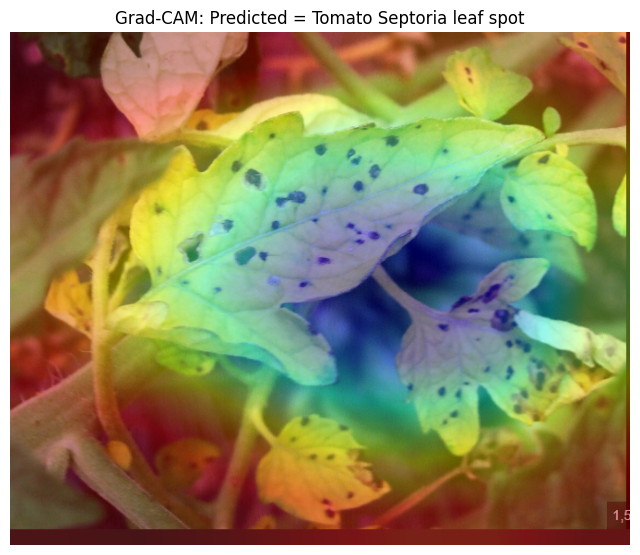

In [41]:
generate_gradcam(model, "plantleaf1.png", train_dataset.classes)
